Tutorial 8: Astronomy Example
=============================

In this tutorial, we'll apply the tools we've learned in this chapter to tackle a read world problem and fit
2D Hubble Space Telescope imaging data of galaxies.

One of the most well-known results in astronomy is the Hubble sequence, which classifies galaxies based on their
visual appearance. The sequence is divided into three broad groups:

- **Early-type**: Galaxies that are round in shape with a smooth blob of light, often called a "bulge".

- **Late-type**: Galaxies that are elliptical in shape with a flattened light distribution, often called a "disk".

- **Irregular**: Galaxies that do not have a regular shape.

Here is the Hubble Sequence, showing early-type galaxies on the left and late-type galaxies on the right:

![Hubble Sequence](https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/hubble_sequence.png?raw=true)

This example fits a Hubble Space Telescope image of a galaxy with two models: one representing bulge-like early-type
galaxies and one representing disk-like late-type galaxies. This will help us determine whether the galaxy is an early
or late-type galaxy.

The aim of this example is to illustrate that everything you have learnt in this chapter can be applied to real-world
problems, and to show you how many of the tools and challenges you have learnt about are used in practice.

After fitting the Hubble Space Telescope data, we will explore some common model-fitting problems astronomers face
when classifying galaxies and measuring their properties. This will be an open exercise for you to consider how these
problems can be addressed.

__Overview__

In this tutorial, we will:

- Use the tools from tutorials 1, 2, and 3 to set up a model that fits 2D astronomical images of galaxies with light 
  profile models.
  
- Encounter and discuss the challenges of model fitting described in tutorial 4, along with strategies to overcome 
  these challenges.
  
- Use the result properties introduced in tutorial 5 to interpret the model fit and determine whether the galaxy is an 
  early or late-type galaxy.

 __Contents__

- **Plot**: Convensional plotting functions for 2D data and grids of 2D coordinates.
- **Data**: Load and plot Hubble Space Telescope imaging data of a galaxy.
- **Mask**: Apply a mask to the data to remove regions of the image that are not relevant to the model fitting.
- **PSF**: Load and plot the Point Spread Function (PSF) of the telescope.
- **Grid**: Create a grid of (y,x) coordinates that overlap the observed galaxy data.
- **Light Profiles**: Define light profile classes representing the light of galaxies.
- **Model Data**: Create the model image of a galaxy by convolving its light profile with the PSF.
- **Model**: Define a model with a light profile to fit the galaxy data.
- **Analysis**: Define the log likelihood function, which compares the model image to the observed image.
- **Model Fit**: Fit the model to the data and display the results.
- **Result**: Interpret the model fit to determine whether the galaxy is an early or late-type galaxy.
- **Bulgey**: Repeat the fit using a bulgey light profile to determine the galaxy's type.
- **Extensions**: Illustrate examples of how this problem can be extended and the challenges that arise.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from typing import Tuple

import autofit as af

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2`


__Plot__

We will plot a lot of arrays of 2D data and grids of 2D coordinates in this example, so lets make a convenience 
functions.

In [2]:


def plot_array(array, title=None, norm=None, filename=None):
    plt.imshow(array, norm=norm)
    plt.colorbar()
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.clf()
    plt.close()


def plot_grid(grid, title=None):
    plt.scatter(x=grid[:, :, 0], y=grid[:, :, 1], s=1)
    plt.title(title)
    plt.show()
    plt.clf()
    plt.close()


__Data__

First, let's load and plot Hubble Space Telescope imaging data of a galaxy. This data includes:

1) The image of the galaxy, which is the data we'll fit.
2) The noise in each pixel of this image, which will be used to evaluate the log likelihood.

The noise-map has a few strange off-centre features which are an artefact of the telescope. Don't worry about these
features.

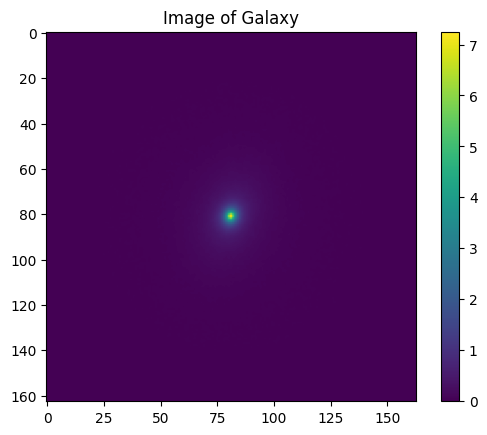

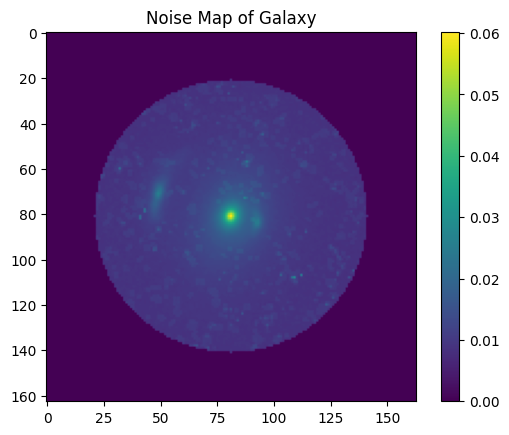

In [3]:
dataset_path = path.join("dataset", "howtofit", "chapter_1", "astro", "simple")

data = np.load(file=path.join(dataset_path, "data.npy"))
plot_array(array=data, title="Image of Galaxy")

noise_map = np.load(file=path.join(dataset_path, "noise_map.npy"))
plot_array(array=noise_map, title="Noise Map of Galaxy")

__Mask__

When fitting 2D imaging data, it is common to apply a mask which removes regions of the image that are not relevant to
the model fitting.

For example, when fitting the galaxy, we remove the edges of the image where the galaxy's light is not visible.

We load and plot the mask below to show you how it is applied to the data, and we will use it in 
the `log_likelihood_function` below to ensure these regions are not fitted.

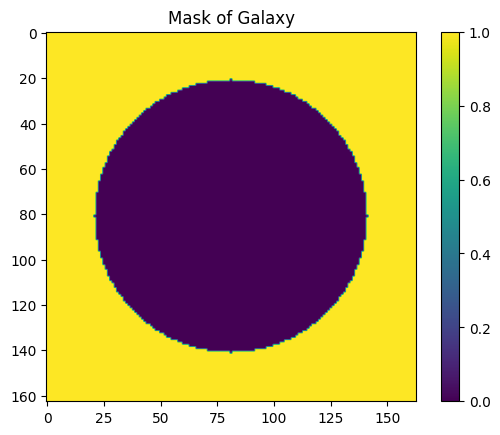

In [4]:
mask = np.load(file=path.join(dataset_path, "mask.npy"))
plot_array(array=mask, title="Mask of Galaxy")

In the image of the galaxy a bright blob of light is clearly visible, which is the galaxy we'll fit with a model.

__PSF__

Another important component of imaging data is the Point Spread Function (PSF), which describes how the light from 
galaxies is blurred when it enters the Hubble Space Telescope.

This blurring occurs due to diffraction as light passes through the HST's optics. The PSF is represented as a 
two-dimensional array, which acts as a 2D convolution kernel.

When fitting the data and in the `log_likelihood_function` below, the PSF is used to create the model data. This 
demonstrates how an `Analysis` class can be extended to include additional steps in the model fitting process.

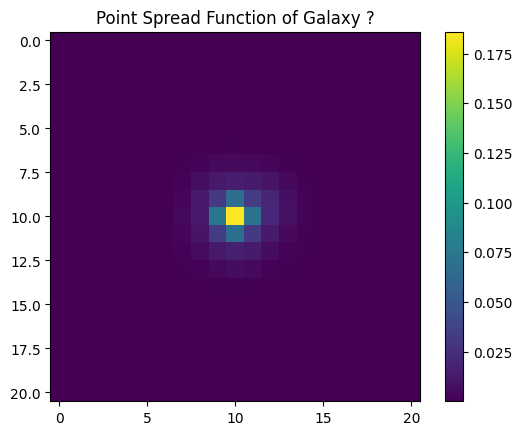

In [5]:
psf = np.load(file=path.join(dataset_path, "psf.npy"))
plot_array(array=psf, title="Point Spread Function of Galaxy ?")

__Grid__

To perform certain calculations, we need a grid of (x,y) coordinates that overlap the observed galaxy data.

We create a 2D grid of coordinates where the origin is (0.0, 0.0) and each pixel is 0.05 in size, matching the 
resolution of our image data.

This grid includes only (y,x) coordinates within the circular mask applied to the data, as we only need to perform 
calculations within this masked region.

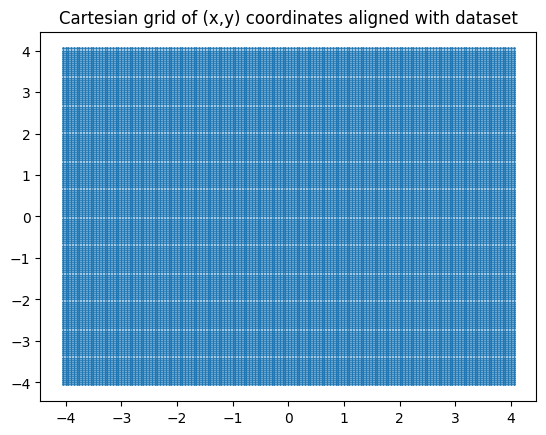

In [6]:
grid = np.load(file=path.join(dataset_path, "grid.npy"))

plot_grid(
    grid=grid,
    title="Cartesian grid of (x,y) coordinates aligned with dataset",
)

__Light Profiles__

Our galaxy model must describe the light of each galaxy, which we refer to as a "light profile." Below, we define two 
light profile classes named `LightBulgey` and `LightDisky`.

These Python classes serve as the model components representing each galaxy's light, similar to the `Gaussian` class 
in previous tutorials. The `__init__` constructor's input parameters (e.g., `centre`, `axis_ratio`, `angle`) are the 
model parameters that the non-linear search will fit.

These classes also include functions that create an image from the light profile based on an input grid of (x,y) 2D 
coordinates, which we will use to generate an image of a light profile. There is a lot of maths going on in these
functions which understanding in detail isn't necessary for you to use **PyAutoFit**. So, if the code below looks
complicated, don't worry about it!

The Python code below uses Python's class inheritance functionality, which novice users may not be familiar with.
Inheritance is the part of the code which reads `class LightProfile(GeometryProfile):`. This means that 
the `LightProfile` class inherits the functions and attributes of the `GeometryProfile` class. 

This is a common object-oriented programming feature in Python, but is not something you need to be familiar with to
use **PyAutoFit**. If the code below is confusing, don't worry about it for now, it won't impact your ability to use
**PyAutoFit**.

In [7]:


class GeometryProfile:
    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        axis_ratio: float = 1.0,
        angle: float = 0.0,
    ):
        """
        Abstract base class for the geometry of a profile representing the light or mass of a galaxy.

        Using the centre, axis-ratio and position angle of the profile this class describes how to convert a
        (y,x) grid of Cartesian coordinates to the elliptical geometry of the profile.

        Parameters
        ----------
        centre
            The (y,x) coordinates of the profile centre.
        axis_ratio
            The axis-ratio of the ellipse (minor axis / major axis).
        angle
            The rotation angle in degrees counter-clockwise from the positive x-axis.
        """

        self.centre = centre
        self.axis_ratio = axis_ratio
        self.angle = angle

    def transformed_to_reference_frame_grid_from(self, grid: np.ndarray):
        """
        Transform a grid of (y,x) coordinates to the geometric reference frame of the profile via a translation using
        its `centre` and a rotation using its `angle`.

        This performs the following steps:

        1) Translate the input (y,x) coordinates from the (0.0, 0.0) origin to the centre of the profile by subtracting
           the profile centre.

        2) Compute the radial distance of every translated coordinate from the centre.

        3) Rotate the coordinates from the above step counter-clockwise from the positive x-axis by the
           profile's `angle`.

        Parameters
        ----------
        grid
            The (y, x) coordinate grid in its original reference frame.
        """

        shifted_grid = grid - self.centre
        effective_radius = (
            (shifted_grid[:, :, 0] ** 2.0 + shifted_grid[:, :, 1] ** 2.0)
        ) ** 0.5

        theta_coordinate_to_profile = np.arctan2(
            shifted_grid[:, :, 1], shifted_grid[:, :, 0]
        ) - np.radians(self.angle)

        transformed_grid = np.zeros(grid.shape)

        transformed_grid[:, :, 0] = effective_radius * np.cos(
            theta_coordinate_to_profile
        )
        transformed_grid[:, :, 1] = effective_radius * np.sin(
            theta_coordinate_to_profile
        )

        return transformed_grid

    def rotated_grid_from_reference_frame_from(self, grid: np.ndarray) -> np.ndarray:
        """
        Rotate a grid of (y,x) coordinates which have been transformed to the elliptical reference frame of a profile
        back to the original unrotated coordinate frame.

        This performs the following steps:

        1) Rotate the coordinates from the elliptical reference frame back to the original unrotated coordinate frame
           using the profile's `angle`.

        2) Translate the coordinates from the centre of the profile back to the (0.0, 0.0) origin by adding the
        profile centre.

        Parameters
        ----------
        grid
            The (y, x) coordinates in the reference frame of an elliptical profile.
        """
        cos_angle = np.cos(np.radians(self.angle))
        sin_angle = np.sin(np.radians(self.angle))

        transformed_grid = np.zeros(grid.shape)

        transformed_grid[:, :, 0] = np.add(
            np.multiply(grid[:, :, 0], cos_angle),
            -np.multiply(grid[:, :, 1], sin_angle),
        )
        transformed_grid[:, :, 1] = np.add(
            np.multiply(grid[:, :, 0], sin_angle), np.multiply(grid[:, :, 1], cos_angle)
        )

        return transformed_grid

    def elliptical_radii_grid_from(self, grid: np.ndarray) -> np.ndarray:
        """
        Convert a grid of (y,x) coordinates to a grid of elliptical radii.

        Parameters
        ----------
        grid
            The (y, x) coordinates in the reference frame of the elliptical profile.
        """

        return (
            (grid[:, :, 1] ** 2.0) + (grid[:, :, 0] / self.axis_ratio) ** 2.0
        ) ** 0.5


class LightProfile(GeometryProfile):
    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        axis_ratio: float = 1.0,
        angle: float = 0.0,
        intensity: float = 0.1,
        effective_radius: float = 0.6,
    ):
        """
        Abstract base class for a light profile, which describes the emission of a galaxy as a
        function of radius.

        Parameters
        ----------
        centre
            The (y,x) coordinates of the profile centre.
        axis_ratio
            The axis-ratio of the ellipse (minor axis / major axis).
        angle
            The rotation angle in degrees counter-clockwise from the positive x-axis.
        intensity
            Overall intensity normalisation of the light profile.
        effective_radius
            The circular radius containing half the light of this profile.
        """

        super().__init__(centre=centre, axis_ratio=axis_ratio, angle=angle)

        self.intensity = intensity
        self.effective_radius = effective_radius


class LightBulgey(LightProfile):
    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        axis_ratio: float = 1.0,
        angle: float = 0.0,
        intensity: float = 0.1,
        effective_radius: float = 0.6,
    ):
        """
        The De Vaucouleurs light profile often used in Astronomy to represent the bulge of galaxies.

        Parameters
        ----------
        centre
            The (y,x) coordinates of the profile centre.
        axis_ratio
            The axis-ratio of the ellipse (minor axis / major axis).
        angle
            The rotation angle in degrees counter-clockwise from the positive x-axis.
        intensity
            Overall intensity normalisation of the light profile.
        effective_radius
            The circular radius containing half the light of this profile.
        """

        super().__init__(
            centre=centre,
            axis_ratio=axis_ratio,
            angle=angle,
            intensity=intensity,
            effective_radius=effective_radius,
        )

    def image_from_grid(self, grid: np.ndarray) -> np.ndarray:
        """
        Returns the image of the De Vaucouleurs light profile on a grid of Cartesian (y,x) coordinates, which are
        first translated to the profile's reference frame.

        Parameters
        ----------
        grid
            The (y, x) coordinates where the image is computed.
        """
        grid_transformed = self.transformed_to_reference_frame_grid_from(grid=grid)
        grid_elliptical_radii = self.elliptical_radii_grid_from(grid=grid_transformed)

        return self.intensity * np.exp(
            -7.66924
            * ((grid_elliptical_radii / self.effective_radius) ** (1.0 / 7.66924) - 1.0)
        )


class LightDisky(LightProfile):
    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        axis_ratio: float = 1.0,
        angle: float = 0.0,
        intensity: float = 0.1,
        effective_radius: float = 0.6,
    ):
        """
        The Exponential light profile often used in Astronomy to represent the disk of galaxies.

        Parameters
        ----------
        centre
            The (y,x) coordinates of the profile centre.
        axis_ratio
            The axis-ratio of the ellipse (minor axis / major axis).
        angle
            The rotation angle in degrees counter-clockwise from the positive x-axis.
        intensity
            Overall intensity normalisation of the light profile.
        effective_radius
            The circular radius containing half the light of this profile.
        """

        super().__init__(
            centre=centre,
            axis_ratio=axis_ratio,
            angle=angle,
            intensity=intensity,
            effective_radius=effective_radius,
        )

    def image_from_grid(self, grid: np.ndarray) -> np.ndarray:
        """
        Returns the image of the light profile on a grid of Cartesian (y,x) coordinates.

        Parameters
        ----------
        grid
            The (y, x) coordinates where the image is computed.
        """
        grid_transformed = self.transformed_to_reference_frame_grid_from(grid=grid)
        grid_elliptical_radii = self.elliptical_radii_grid_from(grid=grid_transformed)

        return self.intensity * np.exp(
            -1.67838
            * ((grid_elliptical_radii / self.effective_radius) ** (1.0 / 1.67838) - 1.0)
        )


Here is an example of an image of a `LightDisky` profile, using the `image_from_grid` method and the
grid aligned with the image of the galaxy.

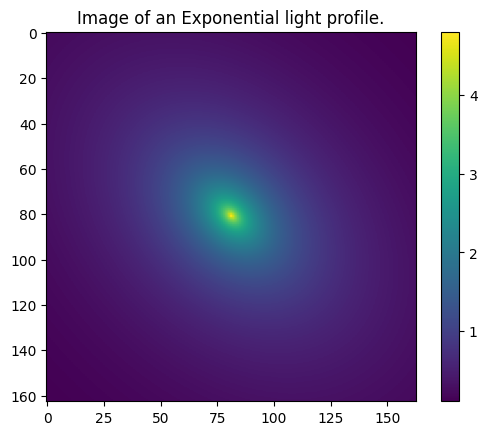

In [8]:
light_profile = LightDisky(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, intensity=1.0, effective_radius=2.0
)
light_image = light_profile.image_from_grid(grid=grid)

plot_array(array=light_image, title="Image of an Exponential light profile.")

__Model Data__

To produce the `model_data`, we now convolve the overall image with the Point Spread Function (PSF) of our observations. 
This blurs the image to simulate the effects of the telescope optics and pixelization used to capture the image.

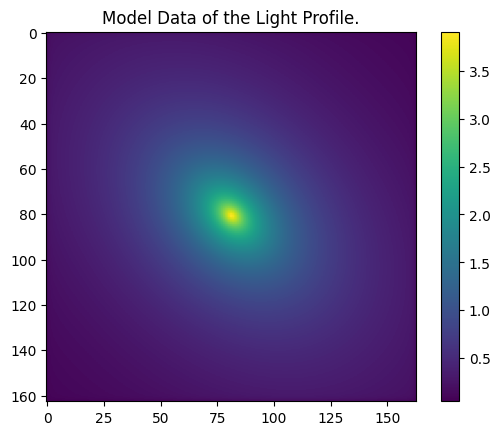

In [9]:
model_data = signal.convolve2d(light_image, psf, mode="same")

plot_array(array=model_data, title="Model Data of the Light Profile.")

By subtracting the model image from the data, we create a 2D residual map, similar to the residual maps we made in 
the 1D Gaussian examples but now for 2D imaging data. It's evident that the random model we used here does not fit 
the galaxy well.

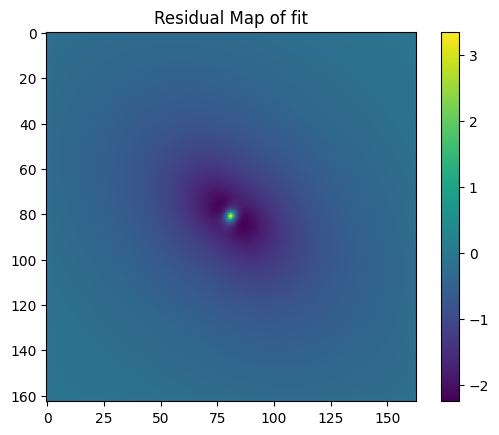

In [10]:
residual_map = data - model_data

plot_array(array=residual_map, title="Residual Map of fit")

Just like in the 1D `Gaussian` fitting examples, we can use the noise map to compute the normalized residuals and 
chi-squared map for the model.

/tmp/ipykernel_3770/1693618666.py:1: RuntimeWarning: divide by zero encountered in true_divide
  normalized_residual_map = residual_map / noise_map


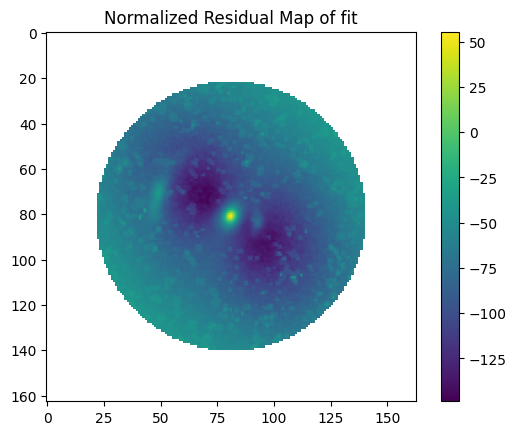

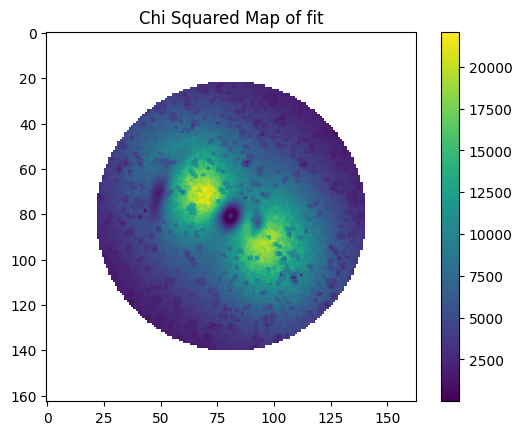

In [11]:
normalized_residual_map = residual_map / noise_map
chi_squared_map = (normalized_residual_map) ** 2.0

plot_array(
    array=normalized_residual_map,
    title="Normalized Residual Map of fit",
)
plot_array(array=chi_squared_map, title="Chi Squared Map of fit")

Finally, we compute the `log_likelihood` of this model, which will be used next to fit the model to the data using 
a non-linear search.

In [12]:
chi_squared = np.sum(chi_squared_map)
noise_normalization = np.sum(np.log(2 * np.pi * noise_map**2.0))

log_likelihood = -0.5 * (chi_squared + noise_normalization)

print(log_likelihood)

nan


/tmp/ipykernel_3770/2965552709.py:2: RuntimeWarning: divide by zero encountered in log
  noise_normalization = np.sum(np.log(2 * np.pi * noise_map**2.0))
/tmp/ipykernel_3770/2965552709.py:4: RuntimeWarning: invalid value encountered in double_scalars
  log_likelihood = -0.5 * (chi_squared + noise_normalization)


__Model__

We now define a model where one of the light profiles defined earlier is encapsulated within a `Model` object. 
This allows us to treat the light profile as a model component that can be used in conjunction with other components. 

Although we are currently using only one light profile in this example, we structure it within a `Collection` for 
potential extension with multiple light profiles.

In [13]:
model = af.Collection(light_0=af.Model(LightDisky))

The `model` operates the same as the model components we've utilized previously. 

Fitting 2D data is more time-consuming than 1D Gaussian data. I therefore employ the prior tuning method described in 
tutorial 4 to speed up the fit, by adjusting the priors to approximate values close to the correct solution. 
This adjustment is based on thorough fits that were performed using a slow and detailed search in order to locate
the global maxima of the likelihood.

Additionally, I fix the center of the light profile to (0.0, 0.0), where it visually appears to be located. 
This reduces the number of free parameters and simplifies the complexity of the non-linear search.

In [14]:
model.light_0.centre_0 = 0.0
model.light_0.centre_1 = 0.0
model.light_0.angle = af.UniformPrior(lower_limit=100.0, upper_limit=120.0)
model.light_0.axis_ratio = af.UniformPrior(lower_limit=0.6, upper_limit=0.8)
model.light_0.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=1.0)

The model info contains information on all of the model components and priors, including the updates above.

In [15]:
print(model.info)

Total Free Parameters = 4

model                                                                           Collection (N=4)
    light_0                                                                     LightDisky (N=4)

light_0
    centre
        centre_0                                                                0.0
        centre_1                                                                0.0
    axis_ratio                                                                  UniformPrior [7], lower_limit = 0.6, upper_limit = 0.8
    angle                                                                       UniformPrior [6], lower_limit = 100.0, upper_limit = 120.0
    intensity                                                                   LogUniformPrior [4], lower_limit = 0.01, upper_limit = 1000.0
    effective_radius                                                            UniformPrior [8], lower_limit = 0.0, upper_limit = 1.0


__Analysis__

We now define the `Analysis` class for this astronomy example, which will fit the `model` to the image data.

Checkout all the docstrings in this class for details on how the fit is performed to 2D imaging data, including
the role of the mask and PSF.

In [16]:


class Analysis(af.Analysis):
    def __init__(
        self,
        data: np.ndarray,
        noise_map: np.ndarray,
        psf: np.ndarray,
        grid: np.ndarray,
        mask: np.ndarray,
    ):
        """
        The analysis class for the **PyAutoFit** example Astronomy project on galaxy fitting.

        This class contains imaging data of a galaxy and it fits it with a model which represents the light profile of
        the galaxy.

        The imaging data contains:

        1) An image of the galaxy.

        2) The noise in every pixel of that image.

        3) The Point Spread Function (PSF) describing how the optics of the telescope blur the image.

        4) A (y,x) grid of coordinates describing the locations of the image pixels in a unit system, which are used
           to perform calculations.

        5) A mask that removes certain image pixels from the analysis.

        This project is a scaled down version of the Astronomy project **PyAutoGalaxy**, which is one of the
        original projects from which PyAutoFit is an offshoot!

        https://github.com/Jammy2211/PyAutoGalaxy

        Parameters
        ----------
        data
            The image containing the observation of the galaxy that is fitted.
        noise_map
            The RMS noise values of the image data, which is folded into the log likelihood calculation.
        psf
            The Point Spread Function of the telescope, which describes how the telescope blurs the image.
        grid
            The (y, x) coordinates of the image from which the calculation is performed and model image is
            computed using.
        mask
            The 2D mask that is applied to the image data.
        """

        self.data = data
        self.noise_map = noise_map
        self.psf = psf
        self.grid = grid
        self.mask = mask

    def log_likelihood_function(self, instance) -> float:
        """
        The `log_likelihood_function` of the galaxy example, which performs the following step:

        1) Using the model passed into the function (whose parameters are set via the non-linear search) create
        a model image of this galaxy using the light profiles in the `instance`.

        2) Convolve this model image with the Point Spread Function of the telescope, ensuring the telescope optics
        are included in the model image.

        3) Subtract this model image from the data and compute its residuals, chi-squared and likelihood via the
        noise map.

        4) Apply the mask to all these quantities, ensuring the edges of the galaxy are omitted from the fit.

        Parameters
        ----------
        instance
            An instance of the model set via the non-linear search.

        Returns
        -------
        float
            The log likelihood value of this particular model.
        """

        """
        The 'instance' that comes into this method contains the light profiles we setup in the `Model` and `Collection`,
        which can be seen by uncommenting the code below.
        """

        # print("Model Instance:")
        # print("Light Profile = ", instance.light)
        # print("Light Profile Centre= ", instance.light.centre)

        """
        Generate the model data from the instance using the functions of the light profile class above.
        
        See the docstring of the `model_data_from_instance` function for a description of how this works.
        """

        model_data = self.model_data_from_instance(instance=instance)

        """
        In this context of fitting 2D astronomical imaging data, the calculation of residual-map, 
        normalized residual-map, chi-squared-map, and likelihood differs from previous examples such as fitting 1D 
        Gaussians. 
        
        The main difference lies in the incorporation of a mask, which excludes regions where the galaxy is not 
        visible, typically the edges.

        To ensure that the mask influences these calculations correctly, we use the `where` parameter of numpy. 
        This parameter allows us to compute the chi-squared and likelihood only where the mask indicates valid 
        data (where the mask is 0, indicating unmasked regions). This approach ensures that the analysis focuses 
        exclusively on the relevant parts of the galaxy image where meaningful comparisons between the model and 
        data can be made.
        """
        residual_map = np.subtract(
            self.data,
            model_data,
            out=np.zeros_like(data),
            where=np.asarray(self.mask) == 0,
        )

        normalized_residual_map = np.divide(
            residual_map,
            self.noise_map,
            out=np.zeros_like(residual_map),
            where=np.asarray(self.mask) == 0,
        )

        chi_squared_map = np.square(
            np.divide(
                residual_map,
                self.noise_map,
                out=np.zeros_like(residual_map),
                where=np.asarray(mask) == 0,
            )
        )

        chi_squared = float(np.sum(chi_squared_map[np.asarray(self.mask) == 0]))
        noise_normalization = float(
            np.sum(np.log(2 * np.pi * noise_map[np.asarray(mask) == 0] ** 2.0))
        )

        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood

    def model_data_from_instance(self, instance):
        """
        Create the image of a galaxy, including blurring due to the Point Spread Function of the telescope.

        For the purpose of illustrating **PyAutoFit** you do not need to understand what this function is doing, the
        main thing to note is that it allows us to create a model image of a galaxy.

        Nevertheless, if you are curious, it inputs the (y,x) Cartesian grids into the light profiles and evaluates
        the image of the galaxy. Multiple light profiles may be summed to create the overall model image that is fitted.

        The mask is used to zero all values of the model image that are not included in the mask.

        Parameters
        ----------
        instance
            An instance of the model set via the non-linear search.

        Returns
        -------
        image
            The image of this galaxy light profile model.
        """

        overall_image = np.zeros(self.data.shape)

        for light_profile in instance:
            overall_image += light_profile.image_from_grid(grid=self.grid)

        model_data = signal.convolve2d(overall_image, self.psf, mode="same")

        model_data[self.mask == 1] = 0.0

        return model_data


__Model Fit__

We have successfully composed a model and analysis class for the astronomy example. 

We can now fit it to the data using a search. We use the same method as previous examples, nested sampling 
algorithm Dynesty.

In [17]:
search = af.DynestyStatic(
    nlive=500,
    sample="rwalk",  # This makes dynesty run faster, don't worry about what it means for now!
)

analysis = Analysis(data=data, noise_map=noise_map, psf=psf, grid=grid, mask=mask)

print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")



    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-07-16 13:59:08,665 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-07-16 13:59:08,667 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-07-16 13:59:08,667 - root - INFO - Starting new Dynesty non-linear search (no previous samples found).
2024-07-16 13:59:08,731 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-07-16 13:59:08,744 - process 0 - INFO - created
2024-07-16 13:59:08,779 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-07-16 13:59:25,752 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search


11691it [27:19,  7.13it/s, +500 | bound: 133 | nc: 1 | ncall: 67837 | eff(%): 18.104 | loglstar:   -inf < 2120.184 <    inf | logz: 2097.515 +/-  0.202 | dlogz:  0.001 >  0.509] 


2024-07-16 14:26:46,851 - root - INFO - Search complete, returning result
The search has finished run - you may now continue the notebook.


__Result__

The `result` object provides a concise summary of the outcomes from the non-linear search. While many of these values 
may not be directly interpretable for non-astronomers, some are meaningful even without specialized knowledge.

For instance, the `angle` parameter indicates the rotation of the galaxy's light profile counterclockwise from the 
x-axis. In our fit, this value should approximate 110.0 degrees, aligning with the observed orientation of the 
galaxy in the image.

Similarly, the `axis-ratio` represents the ratio of the minor axis to the major axis of the galaxy's light profile. 
A value near 0.7 is expected, reflecting the elliptical shape typical of galaxies.

This illustrates why we perform model-fitting, we can take complex data and infer simple, interpretable properties
from it which provide insight into the physical processes generating the data. This is the core goal of the scientific
method and the use of models to explain observations.

In [18]:
print(result.info)

Bayesian Evidence                                                               2097.51499904
Maximum Log Likelihood                                                          2120.18389616
Maximum Log Posterior                                                           2120.94431968

model                                                                           Collection (N=4)
    light_0                                                                     LightDisky (N=4)

Maximum Log Likelihood Model:

light_0
    intensity                                                                   1.315
    angle                                                                       110.553
    axis_ratio                                                                  0.763
    effective_radius                                                            0.270


Summary (3.0 sigma limits):

light_0
    intensity                                                                   1.3152 (1.3033, 1.

The best way to assess the quality of the fit is to use the visualization techniques introduced in previous tutorials. 

For 2D data, we visualize the model image, residual-map, normalized residual-map, and chi-squared-map as 2D arrays. 
These quantities still have the same meanings as their 1D counterparts. For example, normalized residual-map values 
still represent the sigma values of the residuals, with values greater than 3.0 indicating a poor fit to the data.

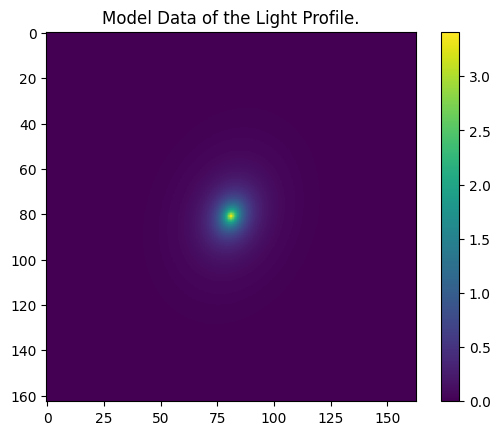

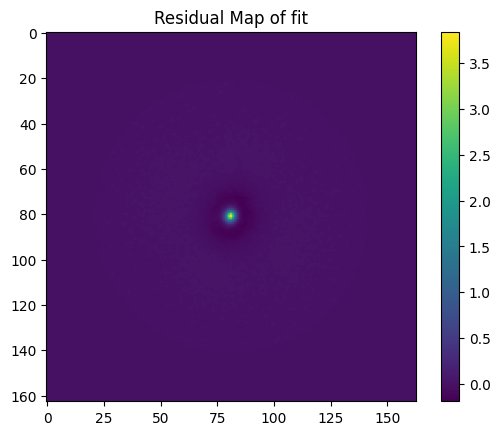

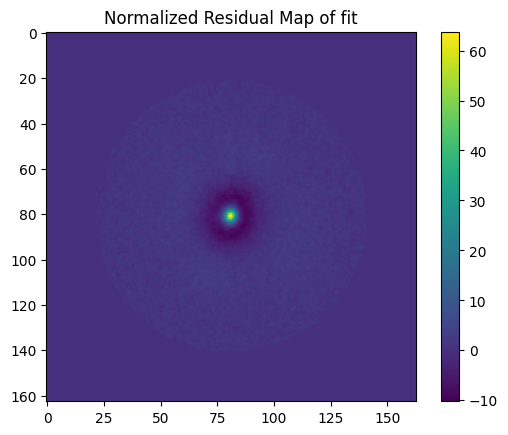

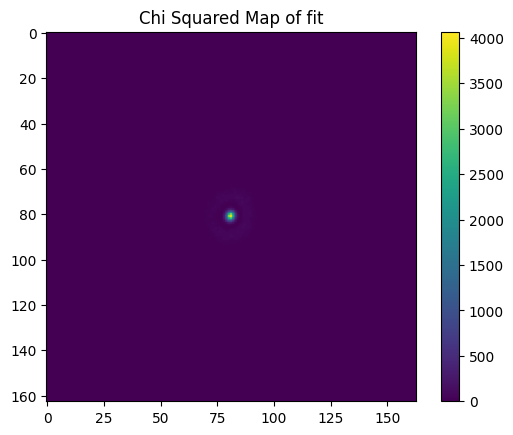

In [19]:
model_data = analysis.model_data_from_instance(
    instance=result.max_log_likelihood_instance
)

residual_map = np.subtract(
    data, model_data, out=np.zeros_like(data), where=np.asarray(mask) == 0
)

normalized_residual_map = np.divide(
    residual_map,
    noise_map,
    out=np.zeros_like(residual_map),
    where=np.asarray(mask) == 0,
)

chi_squared_map = np.square(
    np.divide(
        residual_map,
        noise_map,
        out=np.zeros_like(residual_map),
        where=np.asarray(mask) == 0,
    )
)

plot_array(
    array=model_data,
    title="Model Data of the Light Profile.",
)
plot_array(
    array=residual_map,
    title="Residual Map of fit",
)
plot_array(
    array=normalized_residual_map,
    title="Normalized Residual Map of fit",
)
plot_array(
    array=chi_squared_map,
    title="Chi Squared Map of fit",
)

__Bulgey__

The fit above utilized the disky light profile, which is typically suitable for disk-like late-type galaxies. 

Now, we will repeat the fit using the bulgey light profile, which is more suitable for bulge-like early-type galaxies.

The fit with the higher log likelihood will provide insight into whether the galaxy is more likely to be an early-type 
or a late-type galaxy.

In [ ]:
result_disk = result

model = af.Collection(light_0=af.Model(LightBulgey))

# model.light_0.centre_0 = 0.0
# model.light_0.centre_1 = 0.0
# model.light_0.axis_ratio = af.UniformPrior(lower_limit=0.7, upper_limit=1.0)

print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-07-16 14:26:47,902 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-07-16 14:26:47,903 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-07-16 14:26:47,904 - root - INFO - Starting new Dynesty non-linear search (no previous samples found).
2024-07-16 14:26:47,950 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-07-16 14:26:47,962 - process 0 - INFO - created
2024-07-16 14:26:47,994 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-07-16 14:27:01,791 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search


15304it [30:30,  8.16it/s, bound: 183 | nc: 5 | ncall: 85528 | eff(%): 17.894 | loglstar:   -inf < 33385.458 <    inf | logz: 33349.166 +/-  0.228 | dlogz: 824.616 >  0.509]      

Print the result info of the bulgey fit.

In [ ]:
print(result.info)

We perform the same visualization of the model image, residual-map, normalized residual-map, and chi-squared-map as
before.

The model image of the bulgey profile provides a better fit to the data than the disky profile, as the residuals are
lower and the chi-squared-map values are closer to 0.0.

This suggests that the galaxy is more likely to be an early-type galaxy with a bulge-like light profile.

In [ ]:

model_data = analysis.model_data_from_instance(
    instance=result.max_log_likelihood_instance
)

residual_map = np.subtract(
    data, model_data, out=np.zeros_like(data), where=np.asarray(mask) == 0
)

normalized_residual_map = np.divide(
    residual_map,
    noise_map,
    out=np.zeros_like(residual_map),
    where=np.asarray(mask) == 0,
)

chi_squared_map = np.square(
    np.divide(
        residual_map,
        noise_map,
        out=np.zeros_like(residual_map),
        where=np.asarray(mask) == 0,
    )
)

plot_array(
    array=model_data,
    title="Model Data of the Light Profile.",
)
plot_array(
    array=residual_map,
    title="Residual Map of fit",
)
plot_array(
    array=normalized_residual_map,
    title="Normalized Residual Map of fit",
)
plot_array(
    array=chi_squared_map,
    title="Chi Squared Map of fit",
)

To make certain of our interpretation, we should compare the log likelihoods of the two fits. 

The fit with the highest log likelihood is the preferred model, which (provided your non-linear search sampled 
parameter space accurately), is the bulgey profile.

Therefore, the galaxy is likely an early-type galaxy with a bulge-like light profile.

In [ ]:
print("Disk Model Log Likelihood:")
print(result_disk.log_likelihood)
print("Bulge Model Log Likelihood:")
print(result.log_likelihood)

__Model Mismatch__

The analysis above allowed us to determine whether the galaxy is more likely to be an early-type or late-type galaxy.

However, after fitting the bulgey profile, you may not of expected it to be the highest log likelihood model. The
model gave a relatively poor fit, with significant residuals and chi-squared values. It just turns out that
the disky profile gave an even worse fit!

This reflected the notion of "model mismatch" that we discussed in tutorial 4. One of the challenges of model fitting
is that you may not have a model that is a brilliant representation of the data, and your search is successfully
locating the global maxima even though the fit looks visibly poor.

In Astronomy, what a scientist would do next is update their model to try and improve the fit. For example, they 
may extend the model to contain both the bulgey and disky profile, allowing the model to fit both components of the
galaxy simultaneously. 

There are a whole range of approaches that Astronomers take to improve the model, which include fitting the
galaxy with hundreds of 2D Gaussians, fitting it with a pixel grid of light and decomposing it into what
are called basis functions. These approaches are not relevent to your understanding of **PyAutoFit**, but they
are all implemented in **PyAutoGalaxy** via the **PyAutoFit** API for model composition. 

This is another great example of how **PyAutoFit** can be used to perform complex model-fitting tasks.

__Extensions__

To conclude, I will illustrate some of the extensions that can be made to this example and the challenges that arise
when fitting more complex models.

I don't provide code examples of how to tackle these extensions with model-fitting, but I encourage you to think about
how **PyAutoFit** could be used to address these problems and go ahead and give them a go yourself if you're feeling
adventurous!

**Multiple Components**: 

The model above fitted a single light profile to the galaxy, which turned out to be a bulge-like component. 

However, galaxies often have multiple components, for example a disk and bulge, but also structures such as a bar or
spiral arms. Here is a galaxy with a bulge, disk, bar and spiral arms:

![ngc](https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/ngc1300.jpg?raw=true)
 
To model this galaxy, we would add many different Python classes with their own parameters and light profiles 
representing each component of the galaxy. They would then be combined into a single model, whose model image
would be the summed image of each component, the total number of parameters would be in the twenties or thirties
and the degeneracies between the parameters would be challenging to sample accurately. 

Here is a snippet of rougyly what our model composition would look like:

model = af.Collection(
    bulge=LightBulge,
    disk=LightDisk,
    bar=LightBar,
    spiral_arms=LightSpiralArms
)

This is a great example of how quickly model-fitting can become complex and how keeping track of the speed and
efficiency of the non-linear search becomes crucial. Furthermore, with so many different light profiles to fit,
**PyAutoFit**'s model composition API becomes invaluable.


**Multiple Galaxies**:

There is no reason our imaging data need contain only one galaxy. The data could include multiple galaxies, each
of which we want to fit with its own light profile.

Two galaxies close together are called galaxy mergers, and here is a beautiful example of a pair of merging galaxies:

![merger](https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/merger.jpg?raw=true)

This would pretty much double the model complexity, as each galaxy would have its own model and light profile.
All the usual issues then become doubly important, such as ensuring the likelihood function is efficient, that
the search can sample parameter space accurately and that the results are interpreted correctly.

The model composition would again change, and might look something like:

model = af.Collection(
    bulge_0=LightBulge,
    disk_0=LightDisk,
    bulge_1=LightBulge,
    disk_1=LightDisk
)

model.bulge_0.centre_0 = 2.0
model.bulge_0.centre_1 = 0.0
model.disk_0.centre_0 = 2.0
model.disk_0.centre_1 = 0.0

model.bulge_1.centre_0 = -2.0
model.bulge_1.centre_1 = 0.0
model.disk_1.centre_0 = -2.0
model.disk_1.centre_1 = 0.0

In order to keep the model slightly more simple, the centres of the light profiles have been fixed to where
they peak in the image. 

**PyAutoFit** extensible model composition API actually has much better tools for composing complex models like this
than the example above. You can find a concise run through of these in the model cookbook, but they will
also be the focus on a tutorial in the next chapter of the **HowToFit** lectures.


**Multiple Wavelengths**:

Galaxies emit light in many wavelengths, for example ultraviolet, optical, infrared, radio and X-ray. Each wavelength
provides different information about the galaxy, for example the ultraviolet light tells us about star formation,
the optical light about the stars themselves and the infrared about dust.

The image below shows observations of the same galaxy at different wavelengths:

![multiband](https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/multiwavelength.jpg?raw=true)

In tutorial 6, we learn how to perform fits to multiple datasets simultaneously, and how to change the model
parameterization to account for the variation across datasets. 

Multi-wavelength modeling of galaxies is a great example of where this is useful, as it allows us to fit the galaxy
with certain parameters shared across all wavelengths (e.g., its centre) and other parameters varied (e.g., its
intensity and effective radius). A child project of **PyAutoFit**, called **PyAutoGalaxy**, uses this functionality
to achieve exactly this.

__Chapter Wrap Up__

We have now completed the first chapter of **HowToFit**, which has taught you the basics of model-fitting.

Its now time you take everything you've learnt and apply it to your own model-fitting problem. Think carefully
about the key concepts of this chapter, for example how to compose a model, how to create an analysis class and
how to overcome challenges that arise when fitting complex models.

Once you are familiar with these concepts, and confident that you have some simple model-fitting problems under
your belt, you should move on to the next chapter. This covers how to build a scientific workflow around your
model-fitting, so that you can begin to scale up your model-fitting to more complex models, larger datasets and
more difficult problems. Checkout the `start_here.ipynb` notebook in chapter 2 to get started!